# Prognozowanie w uczeniu statystycznym

## Wstęp
W poniżyszm projekcie postaram się przeanalizować dane dotyczące wpływu poszczególnych chorób oraz czynności wpływających na śmierć podczas udaru. Celem projektu jest stworzenie jak najskuteczniejszego modelu, który na podstawie danych będzie w stanie stworzyć prognozę, czy dana osoba przeżyje czy umrze w przypadku udaru. 

## Wykorzystywane metody
W projekcie zostaną zastosowane 3 metody uczenia statystycznego:
- regresja logsityczna
- Analiza dyskriminacyjna (LDA i QDA)
- metoda naiwna Bayesa


Kolejno zostaną one zastosowane, a następnie porównane ze sobą w celu znalezienia najlepszego modelu.

## UWAGA DO INTERPRETACJI PROJEKTU!!!!
W danych na stronie oznaczenie przedstawiało, że 1 - zgon, a 0 - przeżycie w przypadku udaru. Jak się później okazało, 'jedynki' to znaczą większość przypadków, a dodatkowo z danych wynikałoby, że osoby, które umierają na udar są młodsze, zdrowsze, niepalące, itp. Wydało mi się to skrajnie nieprawdopodobne, a w połączeniu z danymi medycznymi o śmiertelności po udarze (jest to znacznie mniej niż 80%+) postanowiłem przyjąć, że jest na odwrót. Dlatego w tym projekcie według interpretacji 1 - PRZEŻYCIE UDARU/ 0 - ZGON. 
PS. Próbowałem się kontaktować z tym pytaniem przez email, jednak nie otrzymałem odpowiedzi na dwa wysłane maile. Jeżeli moje założenia co do 'udaru' są błędne - przepraszam.

## Wczytywanie bibliotek


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

## Wczytywanie danych

In [2]:
df = pd.read_excel('udar2.xlsx')
df

,udar,wiek,cholesterol,cukrzyca,nadcisnienie,palenie,migrena
0,1,62,194,0,0,0,0
1,1,66,237,0,0,0,0
2,1,66,153,0,0,0,1
3,1,64,219,1,0,0,0
4,1,70,188,1,1,1,1
...,...,...,...,...,...,...,...
495,1,78,205,0,1,0,0
496,1,51,225,1,0,1,0
497,0,59,191,1,0,0,0
498,1,65,189,0,0,0,0


Dane wstępnie nie potrzbują dodatkowej obróbki. W kolejnych częściach będziemy dzielić je oraz standaryzować

## Dane opisowe i wizualizacja danych

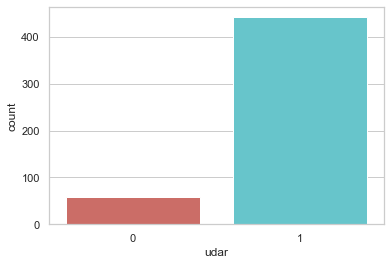

<Figure size 432x288 with 0 Axes>

In [3]:
sns.countplot(x='udar',data=df,palette='hls')
plt.show()
plt.savefig('count_plot')

Na powyższym wykresie widać ile osób przeżyło a ile osób zginęło w przypadku udaru. Istnieje znacząca przewaga osób, które przeyżyły w przypadku wystąpienia udaru.

In [4]:
df.groupby('udar').mean()

,wiek,cholesterol,cukrzyca,nadcisnienie,palenie,migrena
udar,,,,,,
0,66.672414,220.913793,0.758621,0.327586,0.586207,0.379310
1,62.843891,207.581448,0.656109,0.171946,0.393665,0.248869


Dla danych zgrupowanych i podzielonych między te dwie grupy widzimy, że osoby, które zginęły w przypadku udaru średnio częściej chorowały, paliły oraz były starsze. Wydaje się to logicznym następstwem.

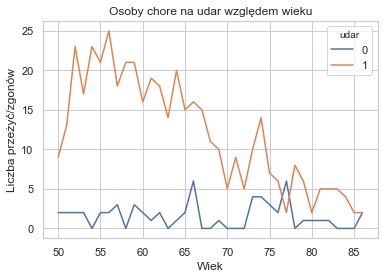

In [5]:
%matplotlib inline
pd.crosstab(df.wiek,df.udar).plot()
plt.title('Osoby chore na udar względem wieku')
plt.xlabel('Wiek')
plt.ylabel('Liczba przeżyć/zgonów')
plt.savefig('Wiek_zgony')

Na powyższym wykresie widzimy jak zmieniał się stosunek liczby przyżyć/zgonów względem wieku. Zdecydowanie maleje ilość liczby osób, które przeżyło wraz z wiekiem, natomiast liczba śmierci pozostaje mniej więcej na podobnym poziomie. Nie wyciągałbym jednak konkretnych wniosków na podstawie tego, ze względu na to, że wiąże się to również z ilością danych dla najstarszych zbadanych osób - ich liczba maleje wraz ze wzrostem wieku, co widać dodatkowo na poniżej zaprezentowanym wykresie:

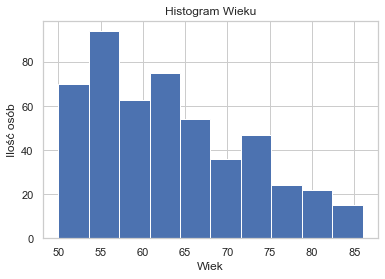

In [6]:
df.wiek.hist()
plt.title('Histogram Wieku')
plt.xlabel('Wiek')
plt.ylabel('Ilość osób')
plt.savefig('hist_age')

Spójrzmy teraz na kolejny, ciekawy wykres. Jest to proporcja osób, które przeżyły względem tych które umarły na udar oraz przy tym posiadały cukrzycę. Może nam to pomóc w podejrzeniach, czy cukrzyca jest wartościowych elementem przy budowie modelu predykcyjnego. Wg poniższego wykresu, róznica nie wydaje się zbyt duża - przynajmniej na oko.

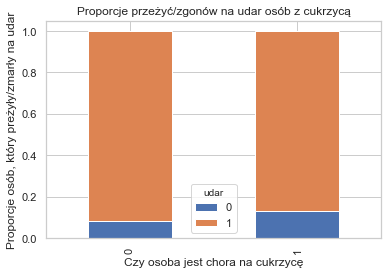

In [7]:
table=pd.crosstab(df.cukrzyca,df.udar)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Proporcje przeżyć/zgonów na udar osób z cukrzycą')
plt.xlabel('Czy osoba jest chora na cukrzycę')
plt.ylabel('Proporcje osób, który preżyły/zmarły na udar')
plt.savefig('cukrzyca_udar')

Dla bliżniaczego wykresu dla nadciśnienie widzimy już większą różnicę, która może sugerować istotny wpływ zmiennej objaśniającej na zmienną objaśnianą

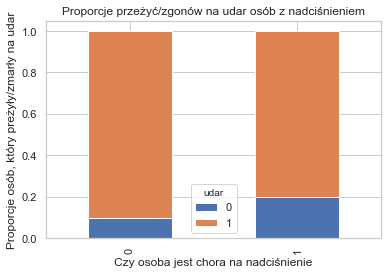

In [8]:
table=pd.crosstab(df.nadcisnienie,df.udar)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Proporcje przeżyć/zgonów na udar osób z nadciśnieniem')
plt.xlabel('Czy osoba jest chora na nadciśnienie')
plt.ylabel('Proporcje osób, który preżyły/zmarły na udar')
plt.savefig('nadcisnienie_udar')

Na kolejnym wykresie uwzględniającym osoby palące widzimy ponownie dość dużą różnicę. To wszystko wydaje się logiczne i może sugerować, że osoby chore na różne przypadłości mają większą szanse zginąć od udaru, niż osoby zdrowe.

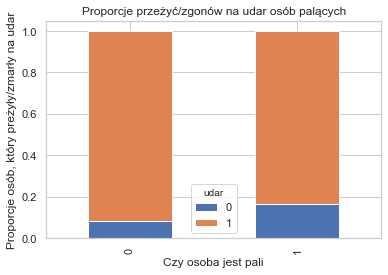

In [9]:
table=pd.crosstab(df.palenie,df.udar)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Proporcje przeżyć/zgonów na udar osób palących')
plt.xlabel('Czy osoba jest pali')
plt.ylabel('Proporcje osób, który preżyły/zmarły na udar')
plt.savefig('palenie_udar')

## Regresja logistyczna
W tej części zaczniemy tworzyć pierwszy model predykcyjny - przy pomocy regresji logistycznej. 
Generalnie regresja logistyczna opiera się na specyficznym sposobie wyrażania prawdopodobieństwa.

Zamiast określać prawdopodobieństwo klasycznie, za pomocą stosunku liczby sukcesów do liczby wszystkich prób, oblicza się szansę, czyli stosunek prawdopodobieństwa sukcesu do prawdopodobieństwa porażki.

Zacznijmy od stworzenia dwoch oddzielnych data-setów: ze zmienna udar oraz z pozostałymi zmiennymi:

In [10]:
target = df.loc[:, df.columns != 'udar']
inputs = df.loc[:, df.columns == 'udar']

Teraz podzielimy nasz zbiór na zbiór testowy i uczący się przy zachowaniu odpowiednich proporcji. Przy 500 rekoradach łącznie, możemy sobie pozwolić na podział 75:25

In [11]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(target,inputs,test_size=0.25,random_state=0)

Standaryzacja danych przy użyciu prostej metody StandardScaler()

In [12]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

Tworzymy model regresji liniowej oraz wyznaczamy wartości, jakie zostały przewidziane (y_pred)

In [13]:
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Sprawdzamy skuteczność predykcji porównując zestaw testowy z danymi, które zostałe przewidziane przez model

In [14]:
y_pred = logreg.predict(X_test)
print('Skutecznosc predykcji modelu regresji logsitycznej wynosi: {:.2f}'.format(logreg.score(X_test, y_test)))

Skutecznosc predykcji modelu regresji logsitycznej wynosi: 0.87


Stwórzmy teraz macierz błędów (confusion marix) i sprawdźmy jak wyglądają dokładniej przewidziane dane:

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  0  16]
 [  0 109]]


Niestety, macierz wyników nie znaczy dla nas za dobrze. Okazuje się, że model jest bardzo "optymistyczny" i zakłada, że każda osoba ze zbioru testowego przeżyje. Skuteczność modelu mimo wszystko jest wysoka, jednak ciężko w tym przypadku stwierdzić jego zdolności predykcyjne

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.87      1.00      0.93       109

    accuracy                           0.87       125
   macro avg       0.44      0.50      0.47       125
weighted avg       0.76      0.87      0.81       125



C:\Users\48503\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\48503\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\48503\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Jednym z głównych założeń regresji logistycznej jest to, aby zmmiennei obajśniające w modelu były niezależne od siebie (posiadały niską korelację). W celu sprawdzenia tego użyjemy testu VIF. Dla wartości większej niż 5 w poszczególnej zmiennej powinniśmy usunąć ją z modelu.

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_temp_train1 = sm.add_constant(X_train)
vif_train1 = pd.DataFrame()
vif_train1["VIF Factor"] = [variance_inflation_factor(x_temp_train1.values, i) for i in range(x_temp_train1.values.shape[1])]
vif_train1["features"] = x_temp_train1.columns
pd.set_option('display.max_rows', 300)
print(vif_train1.round(1))
vif_train1_a=vif_train1[vif_train1["VIF Factor"]<5.0]
feat_list=vif_train1_a["features"].tolist()  #save desired features to list
feat_list.remove(feat_list[0])
#print(vif_train1)
X_train=X_train[feat_list] #keep features on feature list only, drop all other features for train
X_test=X_test[feat_list]   #keep features on feature list only, drop all other features for test

   VIF Factor      features
0         1.0         const
1         1.3          wiek
2         1.1   cholesterol
3         1.1      cukrzyca
4         1.5  nadcisnienie
5         1.2       palenie
6         1.1       migrena


Jak widzimy, wartość VIF jest mniejsza niż 5 dla każdej zmiennej, dlatego mogą one zostać w modelu.

Zastosujmy teraz na naszym modelu RFE. Recursive Feature Elimination (RFE) opiera się na idei wielokrotnego konstruowania modelu i wybierania najlepszej lub najgorzej pasującej zmiennej, odkładając ją na bok, a następnie powtarzając proces z pozostałymi zmiennymi.

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
import statsmodels.api as sm
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
target_scaled = pd.DataFrame(scaler.fit_transform(target), columns=target.columns)
logit_model=sm.Logit(inputs, target_scaled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.682882
         Iterations 4
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.903  
Dependent Variable: udar             AIC:              694.8821
Date:               2022-01-17 19:24 BIC:              720.1698
No. Observations:   500              Log-Likelihood:   -341.44 
Df Model:           5                LL-Null:          -179.44 
Df Residuals:       494              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------
wiek             -0.1308   0.1000 -1.3084 0.1907 -0.3268 0.0651
cholesterol      -0.1601   0.0931 -1.7190 0.0856 -0.3426 0.0224
cukrzyca         -0.0762   

Jak widać z modelu logitowego, możemy z góry usunąć takie zmienne jak palenie czy migrena.

In [19]:
#p-value jest wieksze dla 4 zmiennych objasniajacych - wiek, cholesterol, nadcisnienie i palenie. Zacznijmy kolejno od usuwania
#zmiennych od najwiekszej wartosci p-value do najmniejszej
cols = ['wiek','cholesterol','cukrzyca','nadcisnienie']
X=target_scaled[cols]
y=inputs

In [20]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.683777
         Iterations 4
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.905  
Dependent Variable: udar             AIC:              691.7768
Date:               2022-01-17 19:24 BIC:              708.6353
No. Observations:   500              Log-Likelihood:   -341.89 
Df Model:           3                LL-Null:          -179.44 
Df Residuals:       496              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------
wiek             -0.1386   0.0995 -1.3924 0.1638 -0.3336 0.0565
cholesterol      -0.1679   0.0924 -1.8169 0.0692 -0.3489 0.0132
cukrzyca         -0.0900   

Ponawiamy tę czynność do uzyskania wartości p-value poniżej 0.1

In [21]:
cols = ['wiek','cholesterol','nadcisnienie']
X=target_scaled[cols]
y=inputs

In [22]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.684734
         Iterations 4
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.908  
Dependent Variable: udar             AIC:              690.7336
Date:               2022-01-17 19:24 BIC:              703.3774
No. Observations:   500              Log-Likelihood:   -342.37 
Df Model:           2                LL-Null:          -179.44 
Df Residuals:       497              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------
wiek             -0.1242   0.0982 -1.2642 0.2062 -0.3167 0.0684
cholesterol      -0.1671   0.0923 -1.8112 0.0701 -0.3479 0.0137
nadcisnienie     -0.1427   

In [23]:
cols = ['cholesterol','nadcisnienie']
X=target_scaled[cols]
y=inputs
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.686337
         Iterations 4
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.912  
Dependent Variable: udar             AIC:              690.3374
Date:               2022-01-17 19:24 BIC:              698.7666
No. Observations:   500              Log-Likelihood:   -343.17 
Df Model:           1                LL-Null:          -179.44 
Df Residuals:       498              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
cholesterol     -0.1708   0.0920 -1.8553 0.0636 -0.3512  0.0096
nadcisnienie    -0.1915   0.0921 -2.0795 0.0376 -0.3720 -0.0110



In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Skuteczność predykcji naszego modelu wynosi: {:.2f}'.format(logreg.score(X_test, y_test)))

Skuteczność predykcji naszego modelu wynosi: 0.88


C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  0  18]
 [  0 132]]


Widzimy ponownie taki sam wynik w macierzy błędów. Model przewiduje jedynie przeżycie we wszystkich przypadkach

Zobaczmy teraz jak kształtują się dane na krzywej ROC (The receiver operating characteristic). Linia przerywana przedstawia krzywą ROC klasyfikatora czysto losowego; dobry klasyfikator trzyma się jak najdalej od tej linii (w kierunku lewego górnego rogu). 

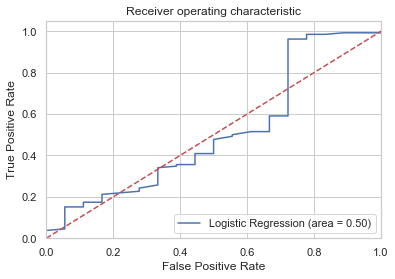

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Niestety, nasz wykres wygląda miernie a sam model może budzić wątpliwości co do skuteczności predykcji. Spróbujmy zbudować modele innymi metodami i sprawdzimy, czy okażą się one lepsze.

## Analiza dyskryminacyjna

W tej części postaramy się zbudować model do analizy dyskryminacyjnej. Zbudujemy dwa modele: Liniowy model dyskryminacyjny (LDA) oraz kwadratowy model dyskrimnacyjny (QDA). 


UWAGA

Wykorzystamy ponownie zestaw danych przystosowany i sprawdzony juz wczesniej ze zmiennymi objasniajacymi cholesterol i nadcisnienie.

Zacznijmy od LDA. przetestujemy w tym miejscu dwie opcje - zwykła LDA oraz LDA z zastosowanym svd. Singular Value Decomposition (svd) jest kolejny algorytmem, który ma nam zredukować wymiary. Algorytm SVD działa poprzez faktoryzację macierzy cech (matrix of features) na trzy macierze, które łączą się za pomocą tego wzoru:

A = U𝚺V^T

gdzie A jest macierzą cech o wymiarach (m x n), U jest macierzą ortogonalną o wymiarach (m x m), V jest macierzą ortogonalną o wymiarach (n x n), a 𝚺 jest nieujemną prostokątną macierzą diagonalną o wymiarach (m x n)

In [27]:
#Podstawowe LDA
LDA_model_default = LinearDiscriminantAnalysis()
LDA_model_default.fit(X_train, y_train)
y_pred_LDA_default =LDA_model_default.predict(X_test)

C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
#LDA - svd
estimator_1 = LinearDiscriminantAnalysis(shrinkage='auto')
parameters_1 = {
    'solver': ('lsqr','eigen'),  
    'n_components': (1,5,1),
                   }
# z funkcją gridSearch
grid_search_lda_A = GridSearchCV(
    estimator=estimator_1,
    param_grid=parameters_1,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
lda_A1=grid_search_lda_A.fit(X_train, y_train)
y_pred_1 =lda_A1.predict(X_test)

C:\Users\48503\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\48503\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\48503\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 577, in fit
    "n_components cannot be larger than min(n_features, n_classes - 1)."
ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

  warnings.warn(some_fits_failed_message, FitFailedWar

Zanim zaczniemy analizę, przeprowadźmy również analizę QDA -  zwykłą oraz z funkcją gridsearch

In [29]:
#Podstawowe QDA
QDA_model_default = QuadraticDiscriminantAnalysis()
QDA_model_default.fit(X_train, y_train)
y_pred_QDA_default =QDA_model_default.predict(X_test)

#Z wykorzystaniem funkcji gridsearch i dobieraniem parametru

estimator_3 = QuadraticDiscriminantAnalysis()
parameters_3 = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=estimator_3,
    param_grid=parameters_3,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
qda_1=grid_search_qda.fit(X_train, y_train)
y_pred_2 =qda_1.predict(X_test)

C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Teraz porównajmy wszystkie wykonane analizy - modele

In [30]:
print('Skuteczność predykcji - LDA:', metrics.accuracy_score(y_test, y_pred_LDA_default)) 
print('Skuteczność predykcji - LDA z wykorzystanie svd:', metrics.accuracy_score(y_test, y_pred_1))
print('Skuteczność predykcji - QDA:', metrics.accuracy_score(y_test, y_pred_QDA_default))
print('Skuteczność predykcji - QDA z wykorzystaniem gridsearch:', metrics.accuracy_score(y_test, y_pred_2))


Skuteczność predykcji - LDA: 0.88
Skuteczność predykcji - LDA z wykorzystanie svd: 0.88
Skuteczność predykcji - QDA: 0.8866666666666667
Skuteczność predykcji - QDA z wykorzystaniem gridsearch: 0.8866666666666667


Algorytm sugeruje większą skuteczność LDA. Wyniki są takie zarówno w przypadku standardowego LDA jak i LDA z wykorzystaniem scv. Podobna sytuacja jest w przypadku QDA. Gridsearch nie wpłynął nam na predykcję.

Sprawdźmy jeszcze macierz przewidzeń

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_2)
print(confusion_matrix)

[[  3  15]
 [  2 130]]


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_1)
print(confusion_matrix)

[[  0  18]
 [  0 132]]


Ciekawą zmianą jest to, że w modelu QDA w końcu pojawiły się pierwsze przewidywania co do zgonu z powodu udaru. Nie były one jednak zbyt skuteczne - 3 poprawnie stwierdzone zgony oraz 2 niepoprawnie stwierdzone przeżycia, jednak wygląda to obiecująco.

Dokładniejszą analizę wykonamy jeszcze w podsumowaniu gdzie prównamy wszystkie wyniki ze sobą, a teraz możemy przejść do stworzenia ostatniego modelu - metoda naiwna Bayesa

## Metoda naiwna Bayesa

Metoda ma stosunkowo proste założenia. Przede wszystkim, główne założenie jest takie, że wszystkie predykatory są niezależne. Często nie mają one żadnego związku z rzeczywistością i właśnie z tego powodu nazywamy tę metodę naiwną. Bardziej opisowe jest określenie "model cech niezależnych".

Metodę tą można wyprowadzić z twierdzenia Bayesa i w dużym skrócie wygląda to następująco:

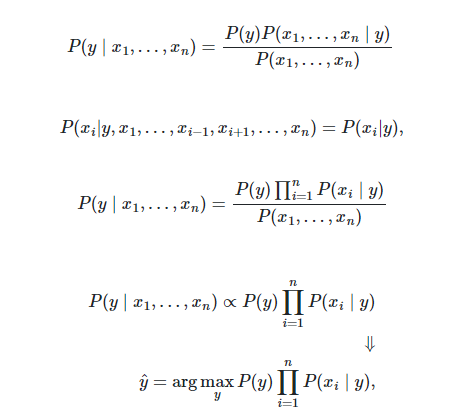

Możemy użyć oszacowania maksimum A Posteriori aby oszacowac P(y) oraz P(xi|y)

Zastosujmy obrobione dane, które był wykorzystane w przypadku regresji logistycznej

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

Stwórzmy teraz model i przetestujmy jego skuteczność

In [34]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
model.score(X_test,y_test)

C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8933333333333333

In [35]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred3  =  classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred3)
print(confusion_matrix)

[[  1  16]
 [  0 133]]


C:\Users\48503\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Jak widać, model działa podobnie jak chociażby LDA czy regresja logistyczna - przewiduje przeżycie praktycznie we wszystkich przypadkach. Dobierałem wiele razy zbiór testowy aby sprawdzić czy są sytuacje, w których zgadnie chociaż 1 zgon i udało się. Oznacza to, że model mimo swojego "optymizmu" co do predykcji, jest w stanie przewidzieć również zgon.

## Podsumowanie

Przejdźmy teraz do merytorycznego podsumowania wraz z porównaniem wszystkich modeli. Zacznijmy od ich skuteczności. UWAGA: W związku z identycznymi przewidywaniami (na naszym zbiorze danych) LDA i LDA z svd ora QDA i QDA z gridsearchem porównamy jedynie ich podstawowe wersje.

In [36]:
print('Skuteczność predykcji - LDA:', metrics.accuracy_score(y_test, y_pred_LDA_default)) 
print('Skuteczność predykcji - QDA:', metrics.accuracy_score(y_test, y_pred_QDA_default))
print('Skuteczność predykcji - Bayes:', metrics.accuracy_score(y_test, y_pred3))
print('Skuteczność predykcji - regresja logistyczna:', metrics.accuracy_score(y_test, y_pred))

Skuteczność predykcji - LDA: 0.8866666666666667
Skuteczność predykcji - QDA: 0.8533333333333334
Skuteczność predykcji - Bayes: 0.8933333333333333
Skuteczność predykcji - regresja logistyczna: 0.8866666666666667


Wszystkie modele mają podobne wyniki, przy czym najlepszy skuteczność predykcji sugeruje przewagę modelu przewidującego metodą naiwną Bayesa. Sprawdźmy teraz macierze wyników dla wszystkich pozycji:

In [47]:
print('LDA')
print('Dokładność predykcji - LDA:', metrics.accuracy_score(y_test, y_pred_LDA_default))  
print('Średnia dokładność predeykcji  - LDA:', metrics.average_precision_score(y_test, y_pred_LDA_default)) 
print('F-score Test (F1 score):', metrics.f1_score(y_test, y_pred_LDA_default)) 
print('Precyzja (precision):', metrics.precision_score(y_test, y_pred_LDA_default)) 
print('Recall - LDA:', metrics.recall_score(y_test, y_pred_LDA_default))
print('ROC Score - LDA:', roc_auc_score(y_test, y_pred_LDA_default))
class_report_RF=classification_report(y_test, y_pred_LDA_default)
print(class_report_RF)
print('')
print('')

print('QDA')
print('Dokładność predykcji - QDA:', metrics.accuracy_score(y_test, y_pred_QDA_default))  
print('Średnia dokładność predeykcji  - QDA:', metrics.average_precision_score(y_test, y_pred_QDA_default)) 
print('F-score Test (F1 score):', metrics.f1_score(y_test, y_pred_QDA_default)) 
print('Precyzja (precision):', metrics.precision_score(y_test, y_pred_QDA_default)) 
print('Recall - QDA:', metrics.recall_score(y_test, y_pred_QDA_default))
print('ROC Score - QDA:', roc_auc_score(y_test, y_pred_QDA_default))
class_report_RF=classification_report(y_test, y_pred_QDA_default)
print(class_report_RF)
print('')
print('')

print('Bayes')
print('Dokładność predykcji - Bayes:', metrics.accuracy_score(y_test, y_pred3))  
print('Średnia dokładność predeykcji  - Bayes:', metrics.average_precision_score(y_test, y_pred3)) 
print('F-score Test (F1 score):', metrics.f1_score(y_test, y_pred3)) 
print('Precyzja (precision):', metrics.precision_score(y_test, y_pred3)) 
print('Recall - Bayes:', metrics.recall_score(y_test, y_pred3))
print('ROC Score - Bayes:', roc_auc_score(y_test, y_pred3))
class_report_RF=classification_report(y_test, y_pred3)
print(class_report_RF)
print('')
print('')

print('Logistic Regression')
print('Dokładność predykcji - LR:', metrics.accuracy_score(y_test, y_pred))  
print('Średnia dokładność predeykcji  - LR:', metrics.average_precision_score(y_test, y_pred)) 
print('F-score Test (F1 score):', metrics.f1_score(y_test, y_pred)) 
print('Precyzja (precision):', metrics.precision_score(y_test, y_pred)) 
print('Recall - LR:', metrics.recall_score(y_test, y_pred))
print('ROC Score - LR:', roc_auc_score(y_test, y_pred))
class_report_RF=classification_report(y_test, y_pred)
print(class_report_RF)
print('')
print('')



LDA
Dokładność predykcji - LDA: 0.8866666666666667
Średnia dokładność predeykcji  - LDA: 0.8866666666666667
F-score Test (F1 score): 0.9399293286219081
Precyzja (precision): 0.8866666666666667
Recall - LDA: 1.0
ROC Score - LDA: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.89      1.00      0.94       133

    accuracy                           0.89       150
   macro avg       0.44      0.50      0.47       150
weighted avg       0.79      0.89      0.83       150



QDA
Dokładność predykcji - QDA: 0.8533333333333334
Średnia dokładność predeykcji  - QDA: 0.8829055397113472
F-score Test (F1 score): 0.9208633093525179
Precyzja (precision): 0.8827586206896552
Recall - QDA: 0.9624060150375939
ROC Score - QDA: 0.48120300751879697
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.88      0.96      0.92       133

    accuracy

C:\Users\48503\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\48503\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\48503\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\48503\anaconda3\lib\site-packages\sklearn\metr

*W ramach wyjasnienia:
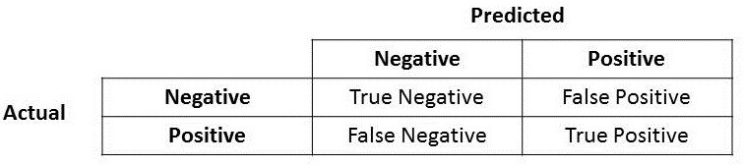

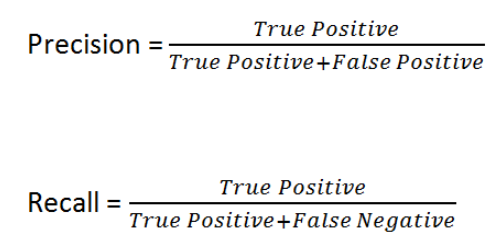

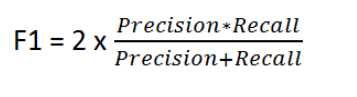

Jak widzimy modele są mocno zbliżone do siebie. Mimo wszystko, model stworzony metodą naiwną Bayesa uzyskała najlepszy wynik. Oprócz przewidzenia wszystkich prawdziwych przeżyć poprawnie, udało mu się również przewidzieć jeden zgon poprawnie, w przeciwieństwie do reszty modeli (oprócz QDA, jednak tam pojawiły się również błędne predykcji co do zgonów, co nie pojawiło się w pozostałych modelach). Wydaje mi się, że zmienne objaśniające mogłby nie być perfekcyjne w tym przypadku i nie dawały one jasnego rozróżnienia dla modelu. Mimo wszystko, skuteczność na poziomie prawie 90% jest zadowalająca. Zastanowić się by można jedynie (tak jak już wcześniej wspominałem), czy ta skuteczność wynika z przewidywania ciągle takiego samego scenariusza, czy rzeczywiście z możliwości predykcyjnych modelu.